# Plot

In [1]:
!pip install plotnine pandas -q

In [50]:
import pandas as pd,os
import plotnine as p9
import warnings
warnings.filterwarnings('ignore')
p9.options.figure_size=(11,8)
from datetime import datetime
now=datetime.now()
date=f'{now.year}-{now.month:02d}-{now.day:02d}'

## Load data

In [31]:
df_all = pd.read_csv('../synthesis/data.jobcensus.synthesized.2021-01-12.csv')
df_all

,JobTitle,JobYear,JobLink,JobType,JobField,JobSource,JobDesc,JobLink_norm
0,Generalist & Non-National Categories,2011,https://www.wikia.org/ | https://www.wikia.org...,Unknown,English Literature,Wiki,Community Colleges\nComparative Literature\nCr...,https://www.wikia.org/ | https://www.wikia.org...
1,AY 2011-12 English Lit Salaries,2011,NaN,TT,English Lit Salaries,Wiki,"Public state university (R2), Midwest. Tenure-...",NaN
2,See Also,2011,http://chronicle.com/article/Average-Faculty-S...,Unknown,English Lit Salaries,Wiki,See also: English Lit Salaries 2010-2011 & Eng...,http://chronicle.com/article/Average-Faculty-S...
3,"Bard College (Annandale-on-Hudson, NY)",2011,NaN,TT,Medieval,Wiki,Position Title: Assistant Professor\nDescripti...,NaN
4,"Bowdoin College (Brunswick, ME)",2011,NaN,Unknown,Medieval,Wiki,From MLA JIL (November 12)\nDescription: Two-y...,NaN
...,...,...,...,...,...,...,...,...
14069,Spanish Language Murphy Visiting Fellowship in...,2020,https://joblist.mla.org/job-details/2880/spani...,Non-TT,Spanish,JIL,"Conway, AR | English, Spanish | Full-time | Ar...",https://joblist.mla.org/job-details/2880
14070,Assistant Professor of Portuguese,2020,https://mlajoblist-js.madgexccstage.com/job-de...,TT,Portuguese,JIL,"US Air Force Academy, Colorado Springs, CO | P...",https://mlajoblist-js.madgexccstage.com/job-de...
14071,Assistant Professor of Russian,2020,https://mlajoblist-js.madgexccstage.com/job-de...,TT,Russian,JIL,"US Air Force Academy, Colorado Springs, CO | L...",https://mlajoblist-js.madgexccstage.com/job-de...
14072,Tenure Track Assistant Professor - Creative Wr...,2020,https://joblist.mla.org/job-details/2694/tenur...,TT,Creative Writing,JIL,"Davis, California | English | Full-time | Cali...",https://joblist.mla.org/job-details/2694


In [32]:
df_alias = pd.read_csv('../synthesis/data.jobcensus.field_aliases.csv')
df_alias

,JobField,FieldAlias,Count
0,20-21 c. American,American: C20-C21,182
1,20th and 21st-Century American,American: C20-C21,6
2,ASL,Languages,2
3,African %26 African American Studies,Ethnic Studies,66
4,African American,Ethnic Studies,219
...,...,...,...
74,Theatre / Drama,Theatre/Drama,32
75,Theory,Critical Theory,16
76,Translation Studies,Translation Studies,13
77,Unknown,Unknown,6


In [33]:
df=df_all.merge(df_alias,on='JobField',how='inner')
# df[df.JobField=='Ethnic Studies']

In [34]:
df['JobYear']=df['JobYear'].apply(int)
# df

In [35]:
# filter
dfm = df
dfm = dfm[dfm.FieldAlias!='--']
# dfm

In [36]:
dfm[dfm.JobField=='Ethnic Studies']

,JobTitle,JobYear,JobLink,JobType,JobField,JobSource,JobDesc,JobLink_norm,FieldAlias,Count
13290,"Full-time, benefits-eligible, non-tenure posit...",2019,NaN,Unknown,Ethnic Studies,Wiki,NaN,NaN,Ethnic Studies,111
13291,Instructor - College of Arts and Sciences,2019,https://www.unomaha.edu/college-of-arts-and-sc...,Non-TT,Ethnic Studies,Wiki,Position in the Interdiscisplinary Studies Pro...,https://www.unomaha.edu/college-of-arts-and-sc...,Ethnic Studies,111
13292,Arcadia University (USA:Pa) - Assistant or Ass...,2019,https://faculty-arcadia.icims.com/jobs/,TT,Ethnic Studies,Wiki,The Department of English at Arcadia Universit...,https://faculty-arcadia.icims.com/jobs/,Ethnic Studies,111
13293,Austin Peay State University (USA:Tn) - Assist...,2019,NaN,TT,Ethnic Studies,Wiki,Position SummaryApplications are invited for t...,NaN,Ethnic Studies,111
13294,Boston University (USA:Ma) - Assistant Profess...,2019,mailto:ensearch@bu.edu,TT,Ethnic Studies,Wiki,The English Department at Boston University in...,mailto:ensearch@bu.edu,Ethnic Studies,111
...,...,...,...,...,...,...,...,...,...,...
13452,University of Albany (USA:Ny) - Visiting Assis...,2019,http://albany.interviewexchange.com/candapply....,Non-TT,Ethnic Studies,Wiki,The Department of Africana Studies is seeking ...,http://albany.interviewexchange.com/candapply....,Ethnic Studies,111
13453,University of Pittburgh (USA:Pa) - Literature ...,2019,NaN,Non-TT,Ethnic Studies,Wiki,The Literature Program at the University of Pi...,NaN,Ethnic Studies,111
13454,University of Pittsburgh (USA: PA) - Lecturer ...,2019,http://www.gsws.pitt.edu/ | https://facultysea...,Non-TT,Ethnic Studies,Wiki,"The Gender, Sexuality and Women’s Studies (GSW...",http://www.gsws.pitt.edu/ | https://facultysea...,Ethnic Studies,111
13455,"Undergradaute Advising/Assistant Professor, Ge...",2019,http://artsandsciences.virginia.edu/home/index...,Non-TT,Ethnic Studies,Wiki,"The University of Virginia, Undergraduate Coll...",http://artsandsciences.virginia.edu/home/index...,Ethnic Studies,111


## Plot 0: All jobs

In [37]:
df_count0 = dfm[dfm.JobType!='Postdoc'].groupby(['JobYear']).count().reset_index()
df_count0

,JobYear,JobTitle,JobLink,JobType,JobField,JobSource,JobDesc,JobLink_norm,FieldAlias,Count
0,2011,877,747,877,877,877,877,747,877,877
1,2012,1136,959,1136,1136,1136,1136,959,1136,1136
2,2013,1638,1369,1638,1638,1638,1638,1369,1638,1638
3,2014,1654,1554,1654,1654,1654,1652,1554,1654,1654
4,2015,1297,1195,1297,1297,1297,1295,1195,1297,1297
5,2016,1208,1126,1208,1208,1208,1208,1126,1208,1208
6,2017,1207,1115,1207,1207,1207,1207,1115,1207,1207
7,2018,1020,930,1020,1020,1020,1017,930,1020,1020
8,2019,799,597,800,800,800,780,597,800,800
9,2020,385,331,386,386,386,385,331,386,386


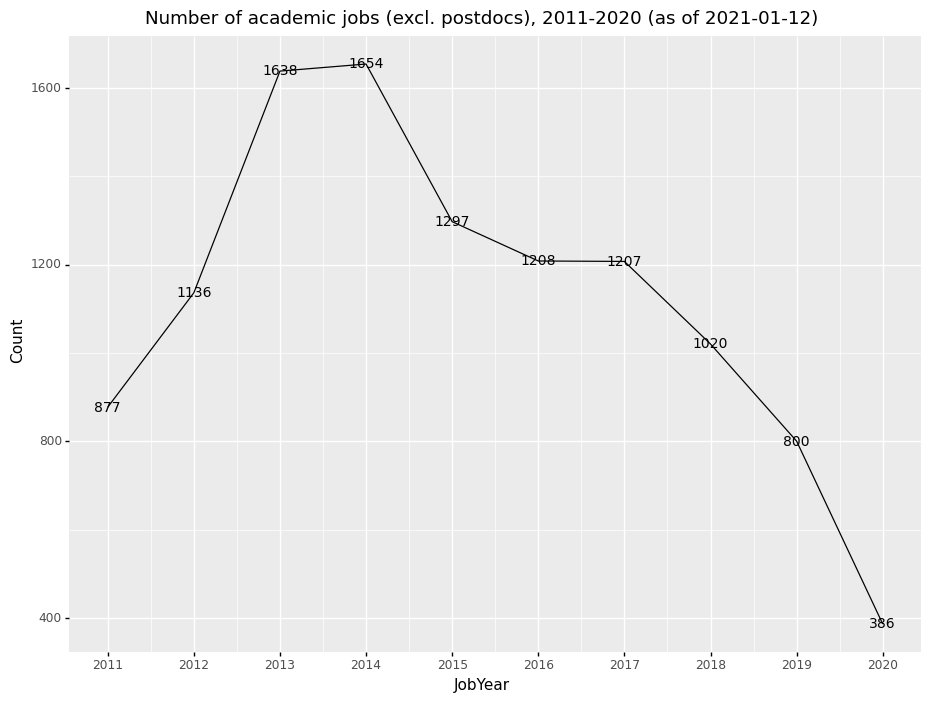

<ggplot: (8726825036377)>

In [38]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count'),df_count0) 
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'),size=10)
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.ggtitle(f'Number of academic jobs (excl. postdocs), 2011-2020 (as of {date})')
)
fig.save(f'figures/fig0.num_jobs.{date}.png',dpi=300)
fig

## Plot 1: By job type

In [39]:
df_count = dfm.groupby(['JobType','JobYear']).count().reset_index()
# df_count

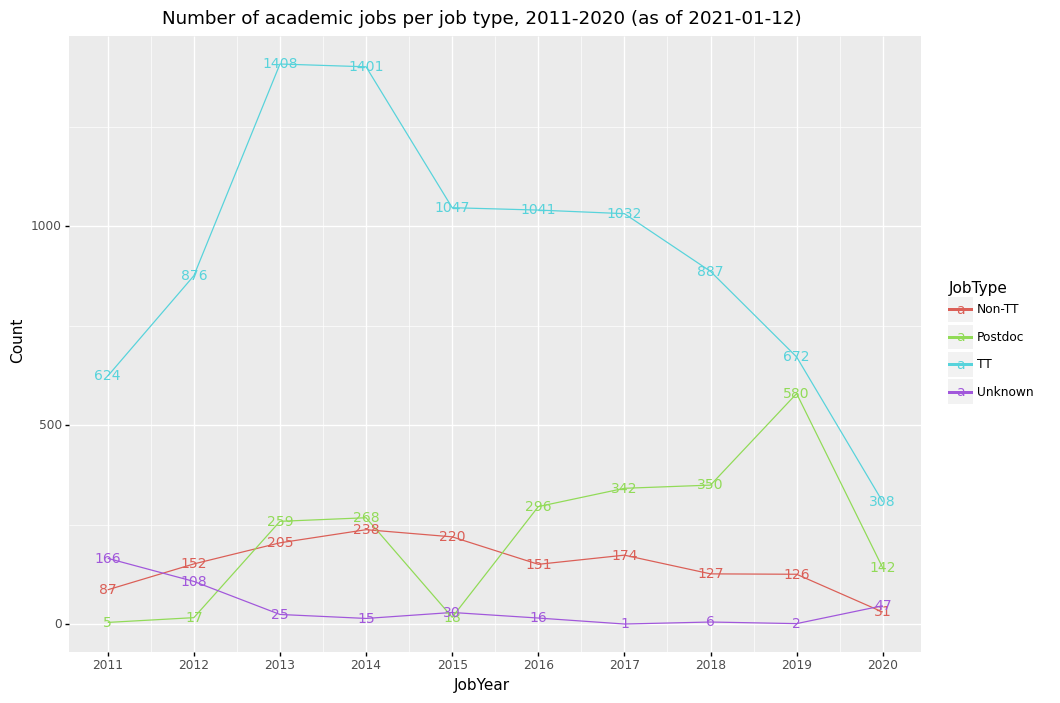

<ggplot: (8726826805241)>

In [40]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count',color='JobType'),df_count) 
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'),size=10)
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.ggtitle(f'Number of academic jobs per job type, 2011-2020 (as of {date})')
)
fig.save(f'figures/fig1.num_jobs_per_type.{date}.png',dpi=300)
fig

## Plot 2: By field (top 10)

In [41]:
# dict(dfm[dfm.JobField=='Ethnic Studies'].iloc[1])

In [42]:
df_count2 = dfm.groupby(['JobYear','FieldAlias']).count().reset_index()
df_count2

,JobYear,FieldAlias,JobTitle,JobLink,JobType,JobField,JobSource,JobDesc,JobLink_norm,Count
0,2011,American: C19/Early,52,45,52,52,52,52,45,52
1,2011,American: C20-C21,37,36,37,37,37,37,36,37
2,2011,Anglophone/Postcolonial,28,24,28,28,28,28,24,28
3,2011,British Open,9,8,9,9,9,9,8,9
4,2011,British: C17-C18,39,34,39,39,39,39,34,39
...,...,...,...,...,...,...,...,...,...,...
235,2020,Poetry,1,1,1,1,1,1,1,1
236,2020,Postdoc,138,113,138,138,138,138,113,138
237,2020,Rhetoric/Composition,47,46,47,47,47,46,46,47
238,2020,Translation Studies,3,2,3,3,3,3,2,3


In [43]:
top10 = dfm[dfm.JobType!='Postdoc'].FieldAlias.value_counts().iloc[:10].index
top10

Index(['Rhetoric/Composition', 'Creative Writing', 'Ethnic Studies',
       'Generalist', 'Gender Studies', 'Theatre/Drama', 'Early Modern',
       'Film Studies', 'Anglophone/Postcolonial', 'Community Colleges'],
      dtype='object')

In [44]:
df_top10 = df_count2[df_count2.FieldAlias.isin(top10)]
df_top10

,JobYear,FieldAlias,JobTitle,JobLink,JobType,JobField,JobSource,JobDesc,JobLink_norm,Count
2,2011,Anglophone/Postcolonial,28,24,28,28,28,28,24,28
7,2011,Community Colleges,7,3,7,7,7,7,3,7
9,2011,Creative Writing,176,135,176,176,176,176,135,176
11,2011,Early Modern,77,64,77,77,77,77,64,77
13,2011,Ethnic Studies,47,35,47,47,47,47,35,47
...,...,...,...,...,...,...,...,...,...,...
227,2020,Ethnic Studies,127,123,127,127,127,127,123,127
228,2020,Film Studies,3,2,3,3,3,3,2,3
229,2020,Gender Studies,14,5,14,14,14,14,5,14
230,2020,Generalist,4,3,4,4,4,4,3,4


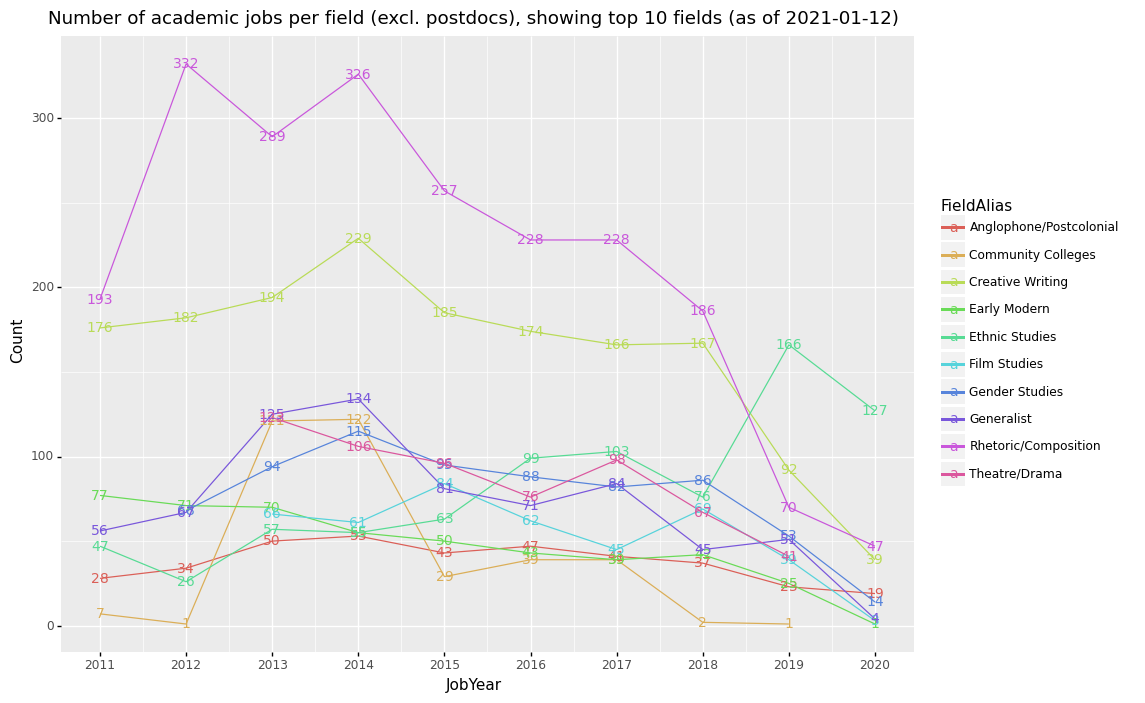

<ggplot: (8726823431769)>

In [45]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count',color='FieldAlias'), df_top10)
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'), size=10)
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.ggtitle(f'Number of academic jobs per field (excl. postdocs), showing top 10 fields (as of {date})')
)
fig.save(f'figures/fig2.num_jobs_per_field_top10.{date}.png',dpi=300)
fig

## Plot 3: By field (all)

In [46]:
df_count3=dfm[dfm.JobType!='Postdoc'].groupby(['JobYear','FieldAlias']).count().reset_index()
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Unknown')]

# not consistently tracked by wiki:
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Languages')] # not tracked by wiki data
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Communication/Media Studies')] # not tracked by wiki data
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Poetry')] # not tracked by wiki data

In [47]:
# add zeros
unique_years = set(df_count3.JobYear)
missing_ld=[]
for field,fielddf in df_count3.groupby('FieldAlias'):
    field_years = set(fielddf.JobYear)
    for year in unique_years - field_years:
        dx=dict(fielddf.iloc[0])
        dx['JobYear']=year
        for k,v in dx.items():
            if not k in {'JobYear','FieldAlias'}:# and type(v)==int:
                dx[k]=0
        missing_ld.append(dx)
df_missing=pd.DataFrame(missing_ld)
df_count3=df_count3.append(df_missing)
df_count3

,JobYear,FieldAlias,JobTitle,JobLink,JobType,JobField,JobSource,JobDesc,JobLink_norm,Count
0,2011,American: C19/Early,52,45,52,52,52,52,45,52
1,2011,American: C20-C21,37,36,37,37,37,37,36,37
2,2011,Anglophone/Postcolonial,28,24,28,28,28,28,24,28
3,2011,British Open,9,8,9,9,9,9,8,9
4,2011,British: C17-C18,39,34,39,39,39,39,34,39
...,...,...,...,...,...,...,...,...,...,...
31,2011,Translation Studies,0,0,0,0,0,0,0,0
32,2012,Translation Studies,0,0,0,0,0,0,0,0
33,2013,Translation Studies,0,0,0,0,0,0,0,0
34,2014,Translation Studies,0,0,0,0,0,0,0,0


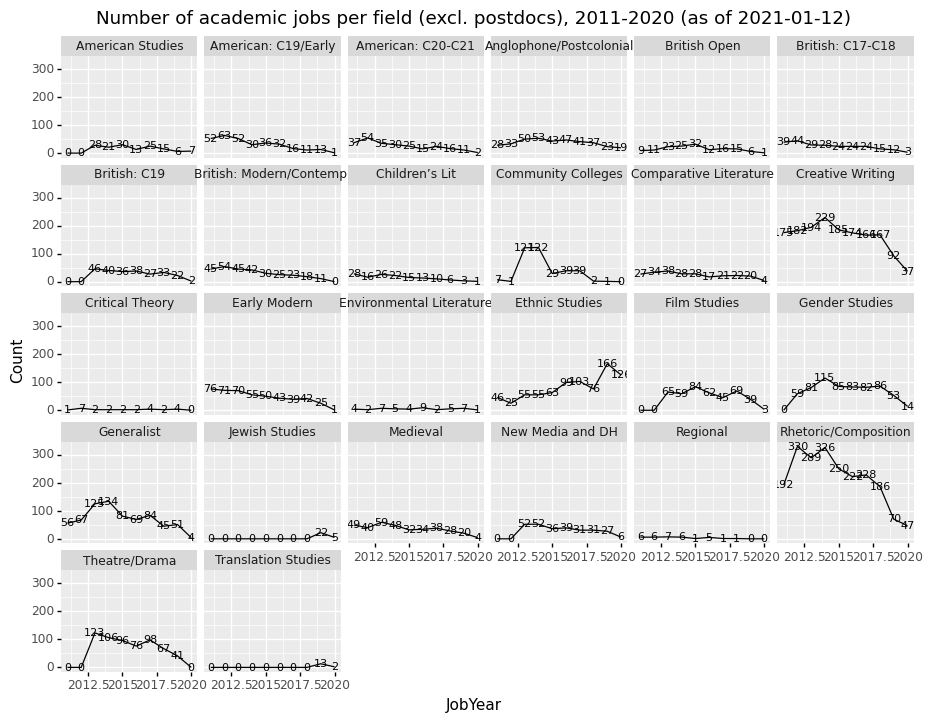

<ggplot: (8726823453289)>

In [48]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count'), df_count3[df_count3.FieldAlias!='Postdoc'])
    + p9.geom_line()
    + p9.facet_wrap('FieldAlias')
    + p9.geom_text(p9.aes(label='Count'),size=8)
    + p9.ggtitle(f'Number of academic jobs per field (excl. postdocs), 2011-2020 (as of {date})')
)
fig.save(f'figures/fig3.num_jobs_per_field_all.{date}.png',dpi=300)
fig

## Explore issues

### Unknown job types?

In [49]:
df_unknown = dfm[(dfm.JobType=='Unknown')]
df_unknown.to_csv('../synthesis/data.unknown_jobtypes.csv',index=False)
df_unknown

,JobTitle,JobYear,JobLink,JobType,JobField,JobSource,JobDesc,JobLink_norm,FieldAlias,Count
1,"Bowdoin College (Brunswick, ME)",2011,NaN,Unknown,Medieval,Wiki,From MLA JIL (November 12)\nDescription: Two-y...,NaN,Medieval,202
3,"Brown University (Providence, RI)",2011,http://chronicle.com/jobs/0000646693-01/,Unknown,Medieval,Wiki,"LINK\nDescription: ""full professor of English ...",http://chronicle.com/jobs/0000646693-01/,Medieval,202
14,Hebrew University of Jerusalem,2011,http://www.hum.huji.ac.il/new.php?cat=3223,Unknown,Medieval,Wiki,Title: Assistant/Associate/Full professor of E...,http://www.hum.huji.ac.il/new.php?cat=3223,Medieval,202
16,Houston Baptist University,2011,http://www.higheredjobs.com/search/details.cfm...,Unknown,Medieval,Wiki,Position Title: full-time faculty English Lite...,http://www.higheredjobs.com/search/details.cfm...,Medieval,202
24,"Penn State Erie, The Behrend College (Erie, PA)",2011,http://behrend.psu.edu/academic/hss/employment...,Unknown,Medieval,Wiki,"LINK\nTitle: tenure track\nDescription: ""Pre-2...",http://behrend.psu.edu/academic/hss/employment...,Medieval,202
...,...,...,...,...,...,...,...,...,...,...
13933,Central Washington University.,2020,https://careers.cwu.edu/psc/careers/EMPLOYEE/H...,Unknown,Chicanx %26 Latinx Studies,Wiki,Central Washington University. Visiting facult...,https://careers.cwu.edu/psc/careers/EMPLOYEE/H...,Ethnic Studies,3
13935,Duke University,2020,NaN,Unknown,Chicanx %26 Latinx Studies,Wiki,Duke University,NaN,Ethnic Studies,3
13936,Texas State University,2020,NaN,Unknown,Chicanx %26 Latinx Studies,Wiki,"Texas State University (San Marcos, TX)",NaN,Ethnic Studies,3
13937,Williams College,2020,NaN,Unknown,Chicanx %26 Latinx Studies,Wiki,"Williams College (Williamstown, MA)",NaN,Ethnic Studies,3
